# Phandelver Probabilities

## Setup

Let's explore some of the dice roll probabilities in the [Lost Mine of Phandelver](https://www.dndbeyond.com/sources/lmop) D&D adventure (on D&D Beyond)!

### Party

The [Pregenerated Characters](https://www.dndbeyond.com/sources/lmop/introduction#PregeneratedCharacters):

1. [Dwarven ClericDwarven Cleric (231 KB PDF)](https://www.dndbeyond.com/file-attachments/0/776/dwarf-cleric.pdf)
2. [Elven Wizard (219 KB PDF)](https://www.dndbeyond.com/file-attachments/0/777/elf-wizard.pdf)
3. [Halfling Rogue (202 KB PDF)](https://www.dndbeyond.com/file-attachments/0/778/halfling-rogue.pdf)
4. [Human Fighter 1 (189 KB PDF)](https://www.dndbeyond.com/file-attachments/0/779/human-fighter.pdf)
5. [Human Fighter 2 (188 KB PDF)](https://www.dndbeyond.com/file-attachments/0/780/human-fighter2.pdf)

### Load Python Code

In [1]:
# Standard library
from itertools import product

# Third-party
import matplotlib.pyplot as plot
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline
plot.style.use("ggplot")


def compute_roll_chance(modifier=0):
    d20 = np.arange(1 + modifier, 21 + modifier)
    disadvantage_roll = (((20 - (d20 - 1 - modifier)) ** 2) / 20**2) * 100
    normal_roll = ((20 - (d20 - 1 - modifier)) / 20) * 100
    advantage_roll = ((20**2 - (d20 - 1 - modifier) ** 2) / 20**2) * 100
    roll_chance = np.array(
        [
            d20.tolist(),
            disadvantage_roll.tolist(),
            normal_roll.tolist(),
            advantage_roll.tolist(),
        ]
    )
    return roll_chance


def print_success_chance_arrays(modifier=0):
    roll_chance = compute_roll_chance(modifier)
    with np.printoptions(formatter={"float": "{:0.2f}".format}):
        print(roll_chance.transpose())


def roll(modifier=0, advantage=False, disadvantage=False):
    roll_chance = compute_roll_chance(modifier)
    if (advantage is True and disadvantage is True) or (
        advantage is False and disadvantage is False
    ):
        row = 2  # normal roll
    elif advantage is True:
        row = 3  # advantage roll
    else:
        row = 1  # disadvantage roll
    return roll_chance, row


def success_chance(dc, modifier=0, advantage=False, disadvantage=False):
    roll_chance, row = roll(modifier, advantage, disadvantage)
    if dc < roll_chance[0][0]:
        return 100
    elif dc > roll_chance[0][-1]:
        return 0
    return roll_chance[row][dc - 1 - modifier]


def plot_success_chance(modifier=0):
    roll_chance = compute_roll_chance(modifier)

    fig, ax = plot.subplots()
    fig.set_size_inches(10, 6)

    ax.bar(roll_chance[0], roll_chance[3], label="advantage")
    ax.bar(roll_chance[0], roll_chance[2], label="normal roll")
    ax.bar(roll_chance[0], roll_chance[1], label="disadvantage")

    ax.set_title(
        "Advantage, normal roll, and disadvantage probabilities\n"
        f"with modifier of {modifier:+1d}"
    )
    ax.set_xlabel("DC (Difficulty Class)")
    ax.set_ylabel("Probability of rolling DC or higher")

    major_ticks = list(range(5 + modifier, 21 + modifier, 5))
    minor_ticks = [
        x
        for x in list(range(1 + modifier, 20 + modifier))
        if x not in major_ticks
    ]
    ax.xaxis.set_major_locator(ticker.FixedLocator(major_ticks))

    ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_ticks))
    ax.xaxis.set_minor_formatter(ticker.ScalarFormatter())
    ax.xaxis.set_tick_params(which="minor", length=4, colors="gray")

    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

    ax.legend()

## D20 Roll Probabilities

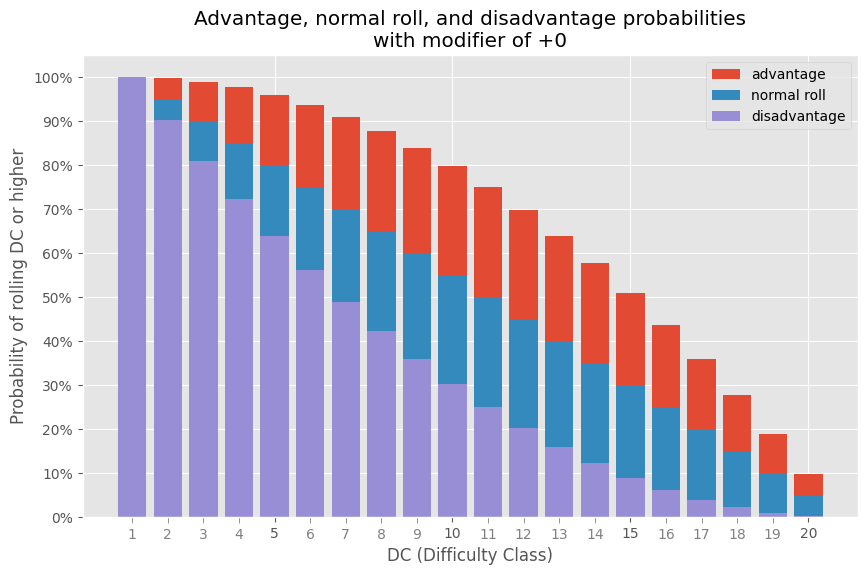

In [2]:
plot_success_chance()

## Goblin Ambush

Four [Goblins](https://www.dndbeyond.com/monsters/16907-goblin) attempt to ambush the party. Their stealth modifier is +6 vs the party's passive perception. Will they surprise everyone in the party?

In [3]:
goblin_stealth_modifier = 6
party_passive_perception = (
    ("Dwarven Cleric:", 13),
    ("Elf Wizard:", 13),
    ("Halfling Rogue:", 10),
    ("Human Fighter 1:", 13),
    ("Human Fighter 2:", 13),
)
total_chance = []
print("Observation chance:")
for player, passive_perception in party_passive_perception:
    chance = 100 - success_chance(
        passive_perception, modifier=goblin_stealth_modifier
    )
    print(f"    {player:<15}{chance: 3.0f}%")
    total_chance.append(chance)
total_chance = np.array(total_chance)
print()
print(
    f"There is only a {total_chance.mean():.0f}% chance the players will see"
    " the hiding goblins."
)

Observation chance:
    Dwarven Cleric: 30%
    Elf Wizard:     30%
    Halfling Rogue: 15%
    Human Fighter 1: 30%
    Human Fighter 2: 30%

There is only a 27% chance the players will see the hiding goblins.


## Initiative Rolls

Initiative, for everyone invovled in this encounter, uses a single die with a flat probability plot. However, the comparison between characters is interesting and we'll use the average to establish order for our purposes:

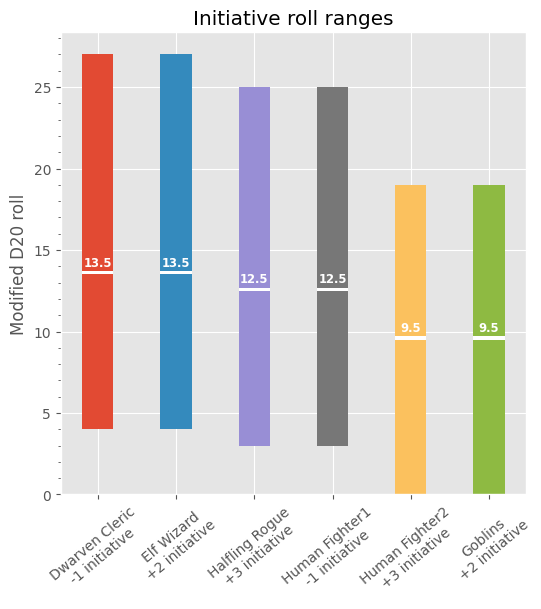

In [4]:
initiative = [
    # Character, Initiative
    ("Dwarven Cleric\n-1 initiative", -1),
    ("Elf Wizard\n+2 initiative", 2),
    ("Halfling Rogue\n+3 initiative", 3),
    ("Human Fighter1\n-1 initiative", -1),
    ("Human Fighter2\n+3 initiative", 3),
    ("Goblins\n+2 initiative", 2),
]

initiative_arrays = []
for creature, modifier in initiative:
    initiative_arrays.append(
        [creature, np.arange(1 + modifier, 21 + modifier)]
    )
initiative_arrays = sorted(
    initiative_arrays, key=lambda x: x[1].mean(), reverse=True
)

fig, ax = plot.subplots()
fig.set_size_inches(6, 6)

i = 1
for player, array in initiative_arrays:
    ax.bar(i, array, width=0.4, bottom=array[0], label=player)
    ax.bar(i, 0.2, width=0.4, bottom=array.mean(), color="white")
    ax.annotate(
        array.mean(),
        (i, array.mean() + 0.5),
        color="white",
        fontsize="small",
        fontweight="bold",
        horizontalalignment="center",
    )
    i += 1

ax.set_title("Initiative roll ranges")
ax.set_ylabel("Modified D20 roll")

ax.xaxis.set_major_locator(
    ticker.FixedLocator(range(len(initiative_arrays) + 1))
)
ax.xaxis.set_major_formatter(
    ticker.FixedFormatter([""] + [item[0] for item in initiative])
)
ax.xaxis.set_tick_params(labelrotation=40)

ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

## Damage Rolls

With initiatve order established, let us investigate the more interesting damage probabilities. For hit probalities, see the [D20 Roll Probabilities](#D20-Roll-Probabilities), above.

We'll only explore the specific damage rolls with interesting (not flat plots). Last we'll compare damage ranges and averages.

The Halfling Rogue who can do sneak attack damage when a fellow party member is adjancent to their target:

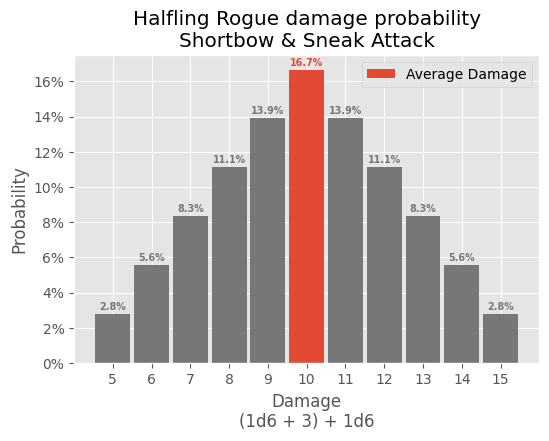

In [5]:
proficiency_modifier = 1
dexterity_modifier = 2
modifier = proficiency_modifier + dexterity_modifier
d6_plus_mod = np.arange(1 + modifier, 7 + modifier)
d6 = np.arange(1, 7)

fig, ax = plot.subplots()
fig.set_size_inches(6, 4)

counts = []
for combination in product(d6_plus_mod, d6):
    counts.append(sum(combination))
counts.sort()
average_damage = int(np.array(counts).mean())
results = np.array(sorted(list(set(counts))))
for result in results:
    if result == average_damage:
        label = "Average Damage"
        color = "C0"
    else:
        label = None
        color = "C3"
    damage_probability = (counts.count(result) / len(d6_plus_mod) ** 2) * 100
    ax.bar(result, damage_probability, color=color, label=label, width=0.9)
    ax.annotate(
        f"{damage_probability:0.1f}%",
        (result, damage_probability + 0.25),
        color=color,
        fontsize="x-small",
        fontweight="bold",
        horizontalalignment="center",
        zorder=5,
    )

ax.set_title("Halfling Rogue damage probability\nShortbow & Sneak Attack")
ax.set_ylabel("Probability")
ax.set_xlabel("Damage\n(1d6 + 3) + 1d6")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

ax.legend()

The Elf Wizard has more interesting attacks in terms of probability. First, we'll investigate the damage probability of the [Magic Missile](https://www.dndbeyond.com/spells/magic-missile) spell at 1st level:

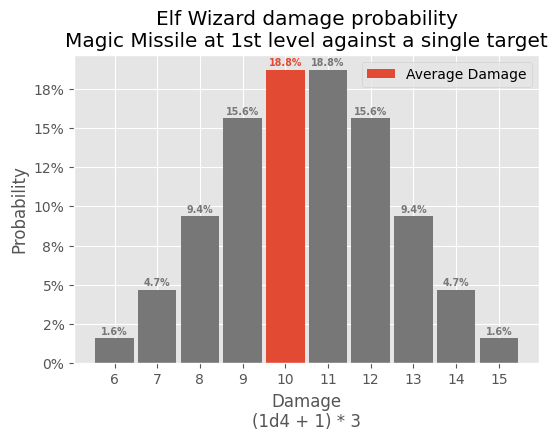

In [6]:
fig, ax = plot.subplots()
fig.set_size_inches(6, 4)

d4_plus_mod = np.arange(1 + 1, 5 + 1)

counts = []
for combination in product(d4_plus_mod, d4_plus_mod, d4_plus_mod):
    counts.append(sum(combination))
counts.sort()
average_damage = int(np.array(counts).mean())
results = np.array(sorted(list(set(counts))))
for result in results:
    if result == average_damage:
        label = "Average Damage"
        color = "C0"
    else:
        label = None
        color = "C3"
    damage_probability = (counts.count(result) / len(d4_plus_mod) ** 3) * 100
    ax.bar(result, damage_probability, color=color, label=label, width=0.9)
    ax.annotate(
        f"{damage_probability:0.1f}%",
        (result, damage_probability + 0.25),
        color=color,
        fontsize="x-small",
        fontweight="bold",
        horizontalalignment="center",
    )

ax.set_title(
    "Elf Wizard damage probability\nMagic Missile at 1st level against a"
    " single target"
)
ax.set_ylabel("Probability")
ax.set_xlabel("Damage\n(1d4 + 1) * 3")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

ax.legend()

Next, we'll investigate the damage probability if the Elf Wizard casts the [Burning Hands](https://www.dndbeyond.com/spells/burning-hands) spell at 1st level:

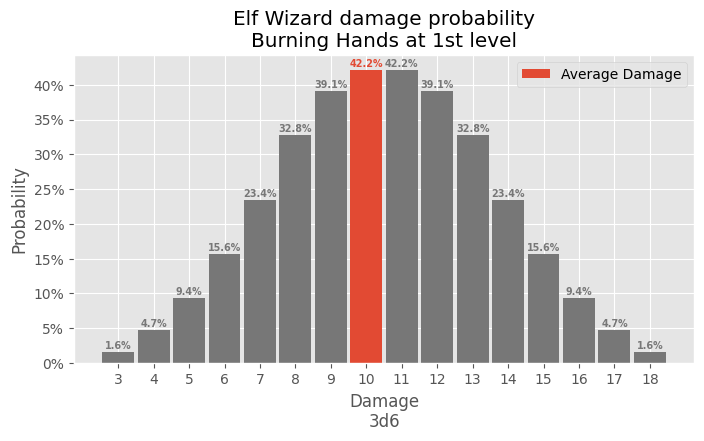

In [7]:
fig, ax = plot.subplots()
fig.set_size_inches(8, 4)

d6 = np.arange(1, 7)

counts = []
for combination in product(d6, d6, d6):
    counts.append(sum(combination))
counts.sort()
average_damage = int(np.array(counts).mean())
results = np.array(sorted(list(set(counts))))
for result in results:
    if result == average_damage:
        label = "Average Damage"
        color = "C0"
    else:
        label = None
        color = "C3"
    damage_probability = (counts.count(result) / len(d4_plus_mod) ** 3) * 100
    ax.bar(result, damage_probability, color=color, label=label, width=0.9)
    ax.annotate(
        f"{damage_probability:0.1f}%",
        (result, damage_probability + 0.5),
        color=color,
        fontsize="x-small",
        fontweight="bold",
        horizontalalignment="center",
    )

ax.set_title("Elf Wizard damage probability\nBurning Hands at 1st level")
ax.set_ylabel("Probability")
ax.set_xlabel("Damage\n3d6")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

ax.legend()

The total damage of the four [Goblins](https://www.dndbeyond.com/monsters/16907-goblin):

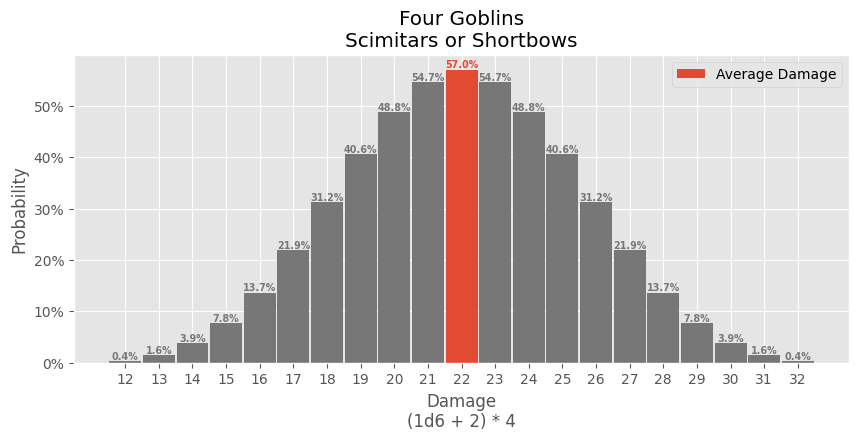

In [8]:
fig, ax = plot.subplots()
fig.set_size_inches(10, 4)

dexterity_modifier = 2
d6_plus_mod = np.arange(1 + dexterity_modifier, 7 + dexterity_modifier)

counts = []
for combination in product(d6_plus_mod, d6_plus_mod, d6_plus_mod, d6_plus_mod):
    counts.append(sum(combination))
counts.sort()
average_damage = int(np.array(counts).mean())
results = np.array(sorted(list(set(counts))))
for result in results:
    if result == average_damage:
        label = "Average Damage"
        color = "C0"
    else:
        label = None
        color = "C3"
    damage_probability = (counts.count(result) / len(d4_plus_mod) ** 4) * 100
    ax.bar(result, damage_probability, color=color, label=label, width=0.95)
    ax.annotate(
        f"{damage_probability:0.1f}%",
        (result, damage_probability + 0.3),
        color=color,
        fontsize="x-small",
        fontweight="bold",
        horizontalalignment="center",
    )

ax.set_title("Four Goblins\nScimitars or Shortbows")
ax.set_ylabel("Probability")
ax.set_xlabel("Damage\n(1d6 + 2) * 4")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

ax.legend()

Last, let's look at optimal damage comparisons (ignoring criticals, but otherwise assuming the best circumstance for each character or monster group). Note that because of the rule of rounding down, the average damage skews lower.

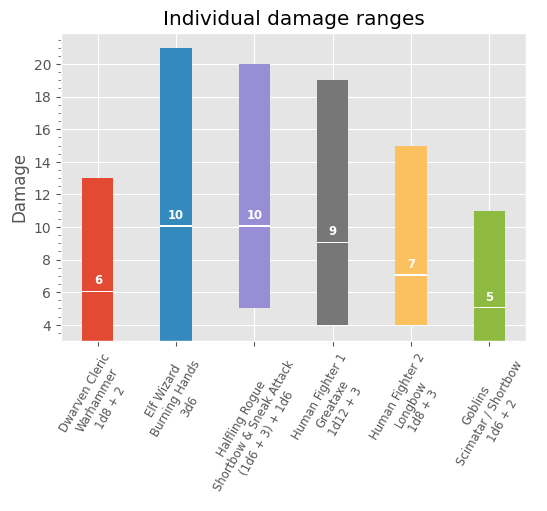

In [9]:
damage = [
    # Character, Damage Array, Damage Average
    ("Dwarven Cleric\nWarhammer\n1d8 + 2", np.arange(3, 11), 6),
    ("Elf Wizard\nBurning Hands\n3d6", np.arange(3, 19), 10),
    (
        "Halfling Rogue\nShortbow & Sneak Attack\n(1d6 + 3) + 1d6",
        np.arange(5, 16),
        10,
    ),
    ("Human Fighter 1\nGreataxe\n1d12 + 3", np.arange(4, 16), 9),
    ("Human Fighter 2\nLongbow\n1d8 + 3", np.arange(4, 12), 7),
    ("Goblins\nScimatar / Shortbow\n1d6 + 2", np.arange(3, 9), 5),
]

fig, ax = plot.subplots()
fig.set_size_inches(6, 4)

i = 1
for character, damage_array, damage_average in damage:
    ax.bar(
        i, damage_array, width=0.4, bottom=damage_array[0], label="x"
    )  # )character)
    ax.bar(i, 0.1, width=0.4, bottom=damage_average, color="white")
    ax.annotate(
        damage_average,
        (i, damage_average + 0.5),
        color="white",
        fontsize="small",
        fontweight="bold",
        horizontalalignment="center",
    )
    i += 1

ax.set_title("Individual damage ranges")
ax.set_ylabel("Damage")

ax.xaxis.set_major_locator(
    ticker.FixedLocator(range(len(initiative_arrays) + 1))
)
ax.xaxis.set_major_formatter(
    ticker.FixedFormatter([""] + [item[0] for item in damage])
)
ax.xaxis.set_tick_params(labelrotation=60, labelsize="small")

ax.yaxis.set_major_locator(ticker.MaxNLocator(steps=(2, 10)))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

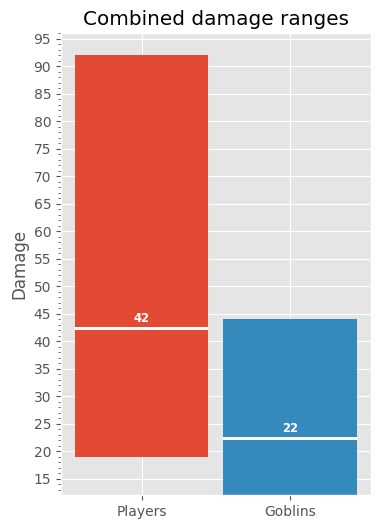

In [10]:
damage = [
    # Group, Damage Array, Damage Average
    ("Players", np.arange(19, 74), 42),
    ("Goblins", np.arange(12, 33), 22),
]

fig, ax = plot.subplots()
fig.set_size_inches(4, 6)

i = 1
for character, damage_array, damage_average in damage:
    ax.bar(
        i, damage_array, width=0.9, bottom=damage_array[0], label="x"
    )  # )character)
    ax.bar(i, 0.6, width=0.9, bottom=damage_average, color="white")
    ax.annotate(
        damage_average,
        (i, damage_average + 1.5),
        color="white",
        fontsize="small",
        fontweight="bold",
        horizontalalignment="center",
    )
    i += 1

ax.set_title("Combined damage ranges")
ax.set_ylabel("Damage")

ax.xaxis.set_major_locator(
    ticker.FixedLocator(range(len(initiative_arrays) + 1))
)
ax.xaxis.set_major_formatter(
    ticker.FixedFormatter([""] + [item[0] for item in damage])
)

ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=17, steps=(5, 10)))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

## Notes and References

- Dice roll averages are rounded down in the spirit of D&D ([Round Down - Basic Rules for Dungeons and Dragons (D&D) Fifth Edition (5e) - D&D Beyond](https://www.dndbeyond.com/sources/basic-rules/introduction#RoundDown))
- [[5e] The math and probability behind rolling with advantage! : DnD[5e] The math and probability behind rolling with advantage! : DnD](https://www.reddit.com/r/DnD/comments/802zzo/comment/dusrx2d/)
- [D&D Probability distributionsD&D Probability distributions](https://www.cl.cam.ac.uk/~rmk35/dropbears.html) (tabular data is inaccurate--off by 1)
- [I made a probability calculator for DnD dice rolls! : DungeonsAndDragons](https://www.reddit.com/r/DungeonsAndDragons/comments/uupw5t/i_made_a_probability_calculator_for_dnd_dice_rolls/)
- [Comment - DnD has led me to discover a rule of probability and I feel like Blaise Pascal : DnDDnD has led me to discover a rule of probability and I feel like Blaise Pascal : DnD](https://www.reddit.com/r/DnD/comments/i36b8b/comment/g0a72bv/) (more complex problems may require simulation instead of maths)
- [ryantam626/jupyterlab_code_formatter](https://github.com/ryantam626/jupyterlab_code_formatter) (note that the extension is configured in Jupyter Lab, not config files)
- Python Documentation
  - [itertools — Functions creating iterators for efficient looping — Python 3.10.9 documentation](https://docs.python.org/3.10/library/itertools.html)